In [5]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

/home/jbelk/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
def hsp90_ligs(all_ligs):
    return [l for l in all_ligs if l not in ['4YKY', '4YKZ', '4YKX']]

def b2ar_data(crystals, glides):
    for l in glides:
        for s in glides[l]:
            for p in glides[l][s].poses:
                for r in glides[l][s].poses[p].fp.feats:
                    if r > 1000:
                        glides[l][s].poses[p].fp.feats[str(int(r) - 1000)] = glides[l][s].poses[p].fp.feats[r]
                        del glides[l][s].poses[p].fp.feats[r]

    for s in crystals:
        for r in crystals[s].fp.feats:
            if r > 1000:
                crystals[s].fp.feats[str(int(r) - 1000)] = crystals[s].fp.feats[r]
                del xcrystals[s].fp.feats[r]

HSP90
Loading crystal structures...
Loading glidescores...
0 of 64 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


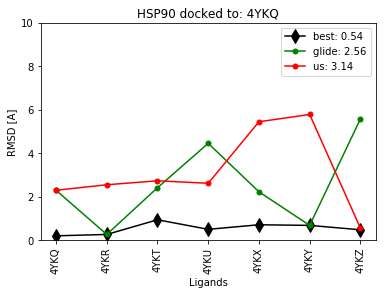

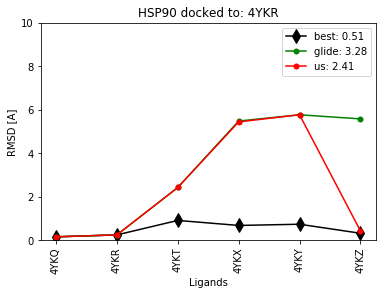

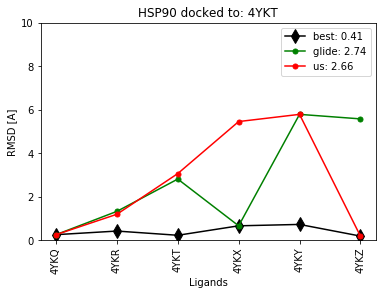

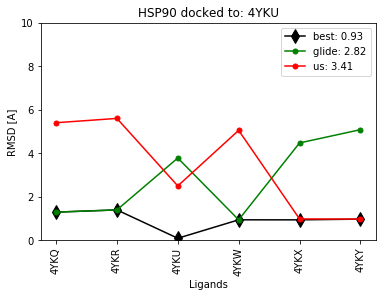

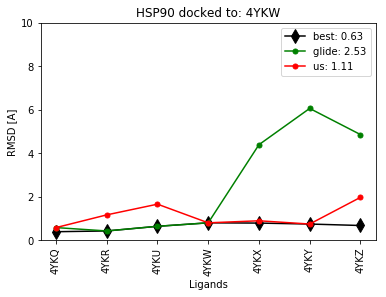

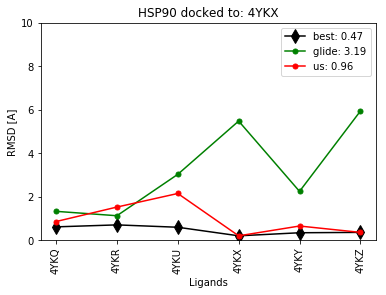

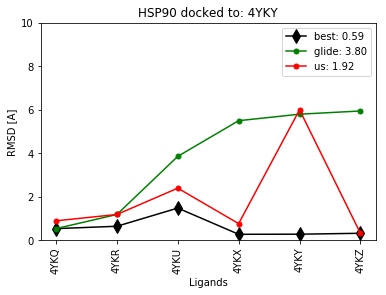

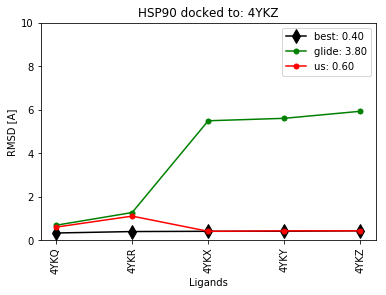

average rmsd across all structures: 2.06348979592 for us, 3.05685714286 for glide
AR
Loading crystal structures...
Loading glidescores...
Loading rmsds...
58 of 361 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


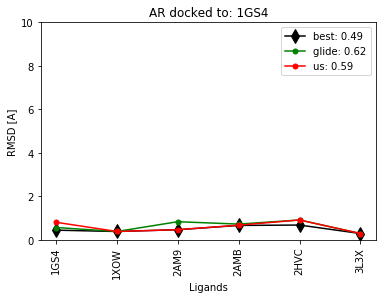

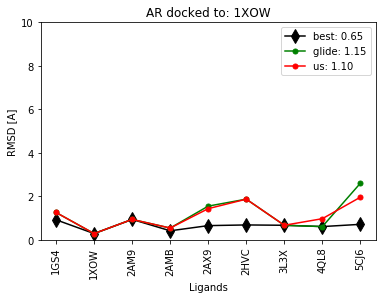

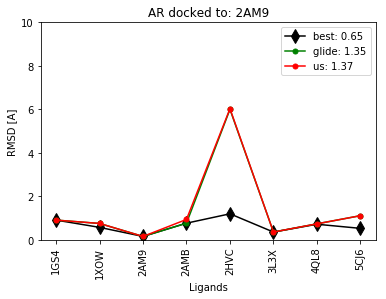

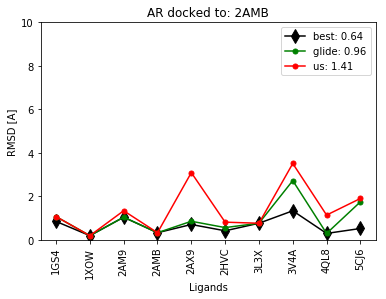

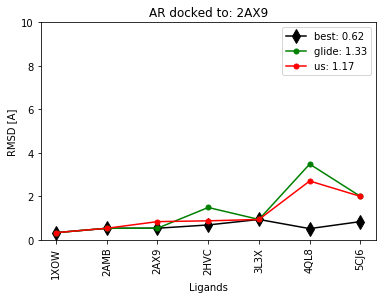

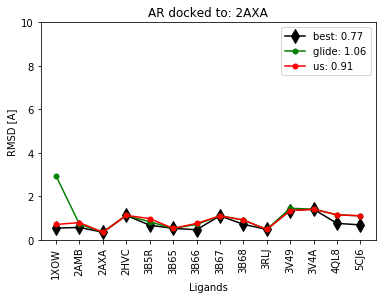

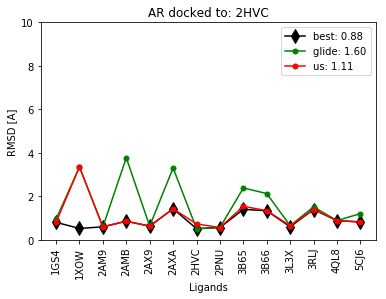

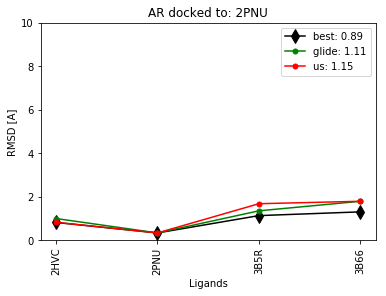

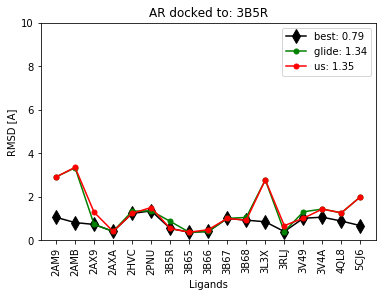

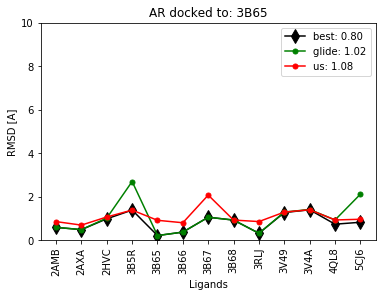

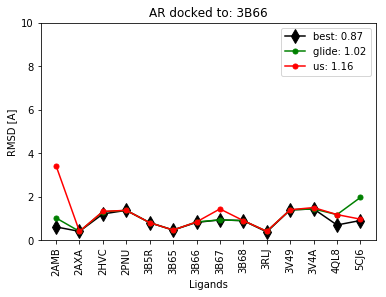

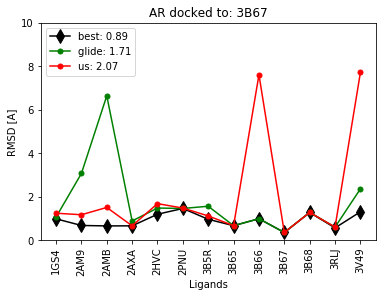

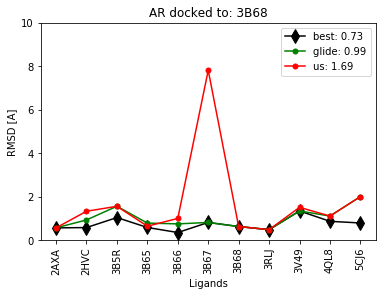

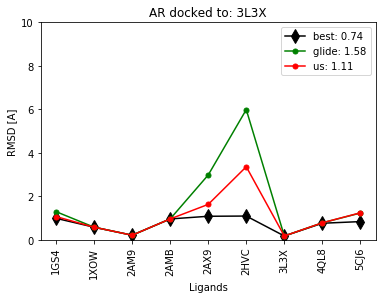

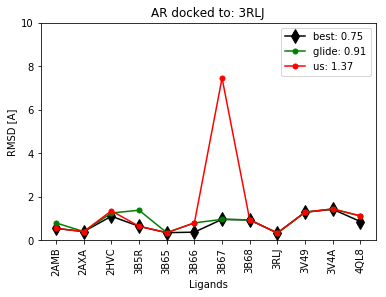

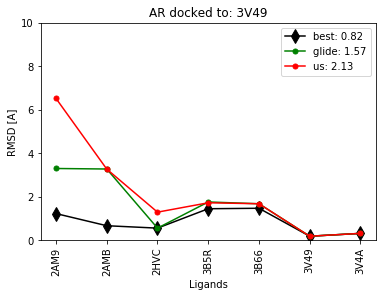

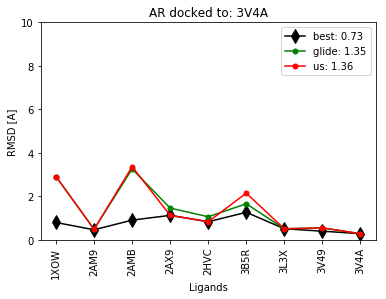

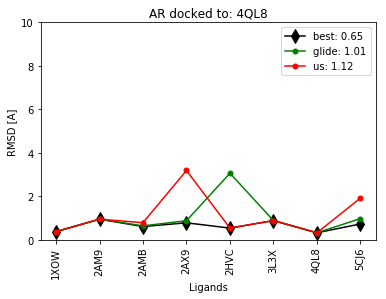

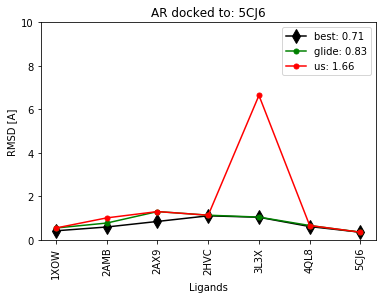

average rmsd across all structures: 1.32073958333 for us, 1.20768229167 for glide
B2AR
Loading crystal structures...
Loading glidescores...
0 of 121 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


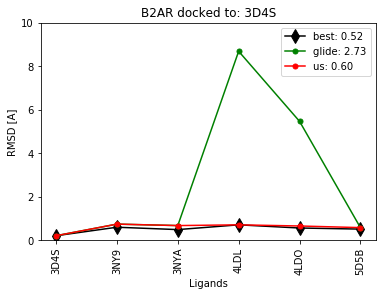

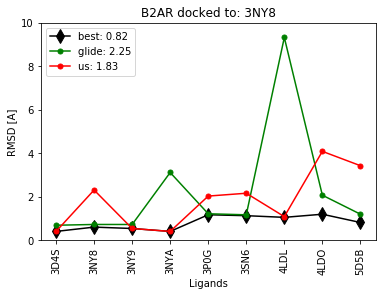

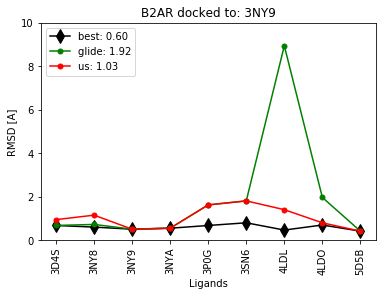

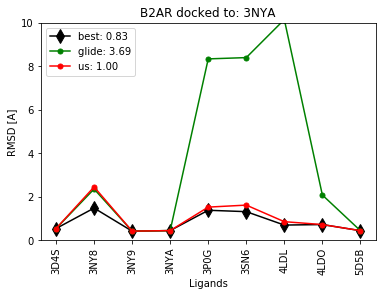

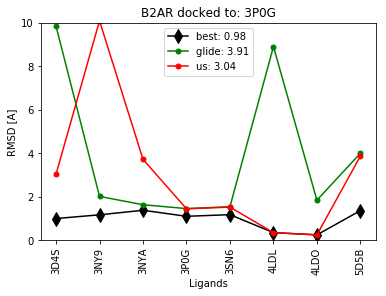

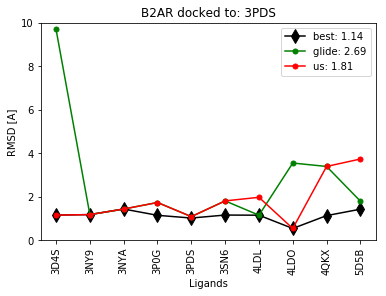

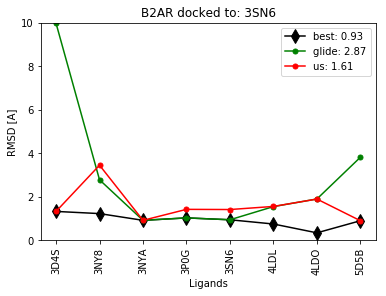

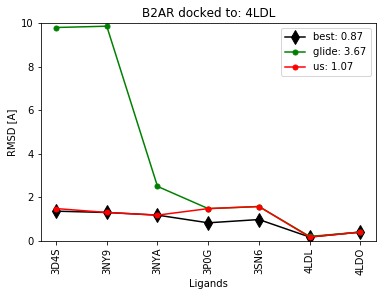

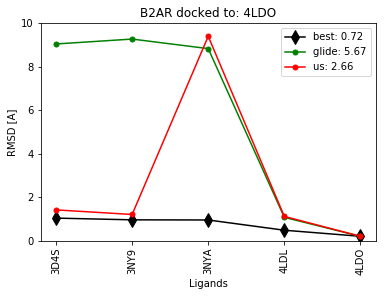

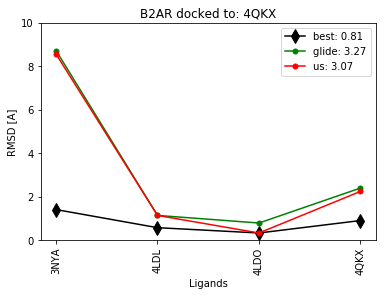

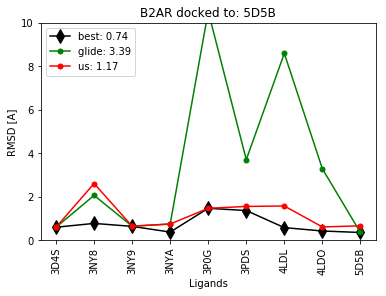

average rmsd across all structures: 1.63863095238 for us, 3.17048809524 for glide
CDK2
Loading crystal structures...
Loading glidescores...
0 of 289 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


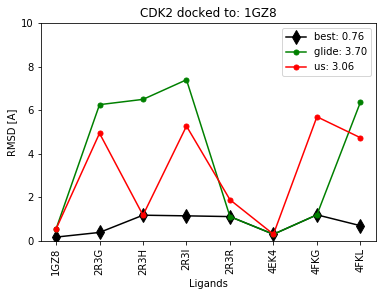

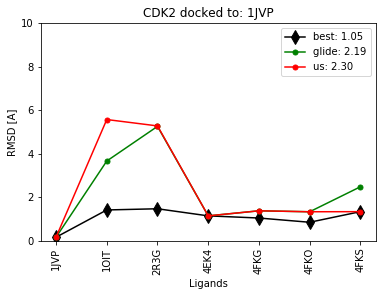

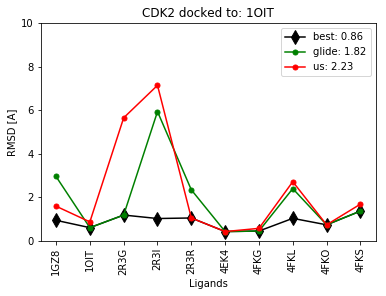

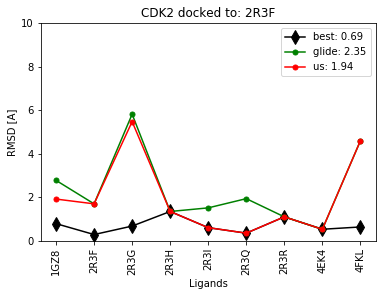

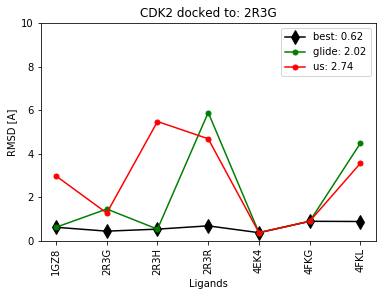

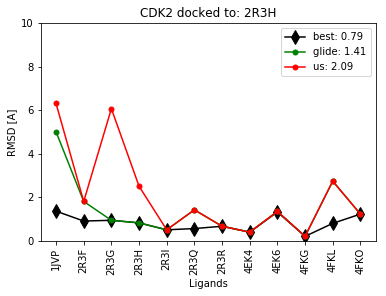

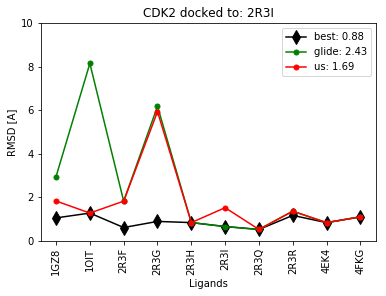

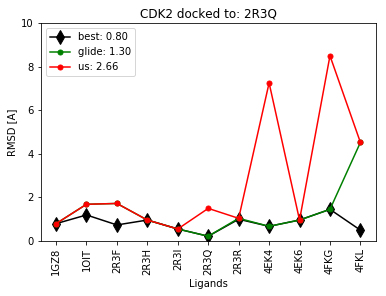

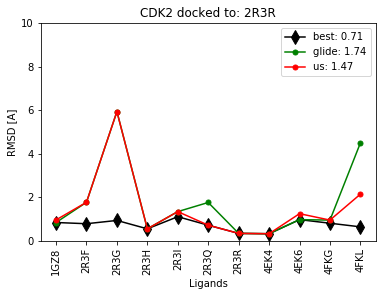

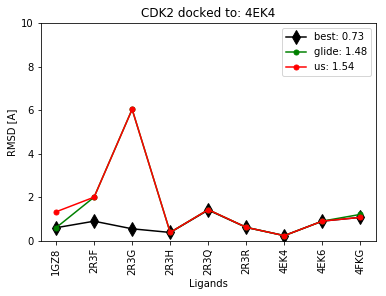

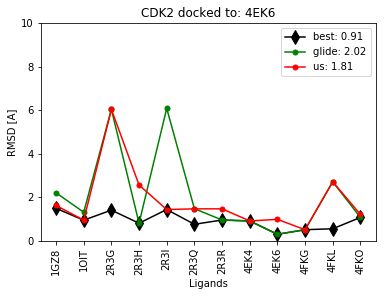

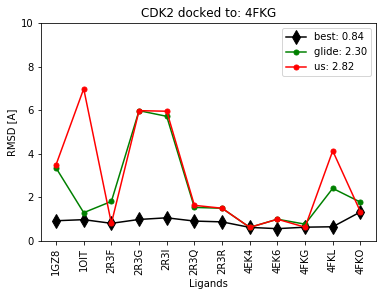

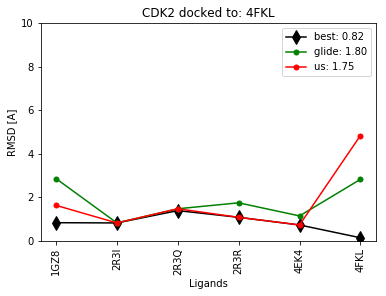

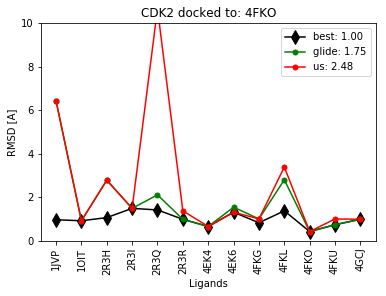

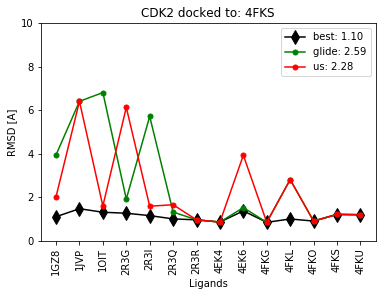

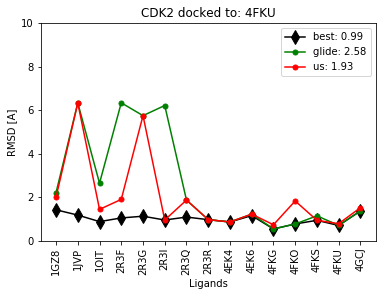

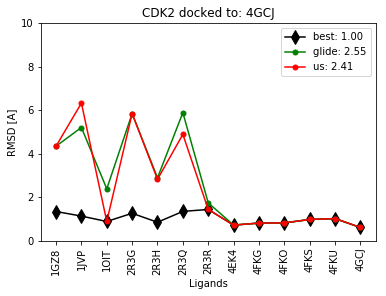

average rmsd across all structures: 2.19068715084 for us, 2.12677653631 for glide
CHK1
Loading crystal structures...
Loading glidescores...
0 of 169 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


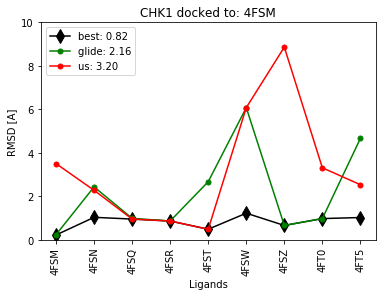

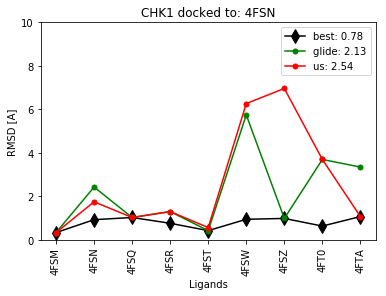

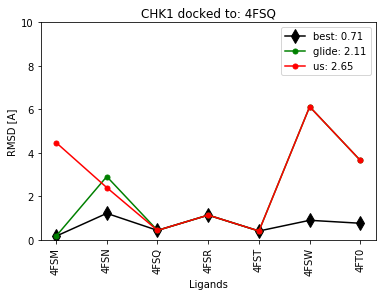

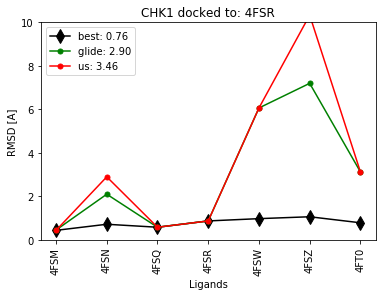

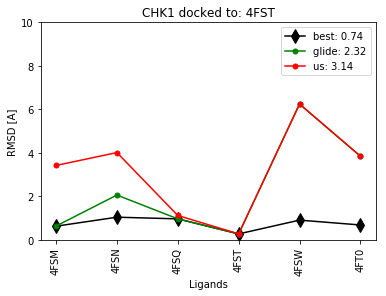

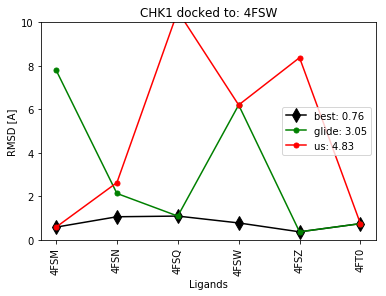

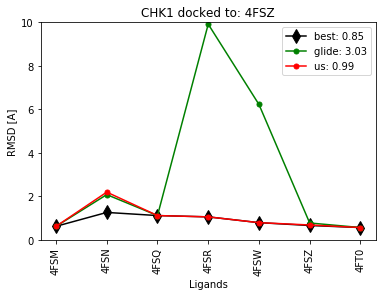

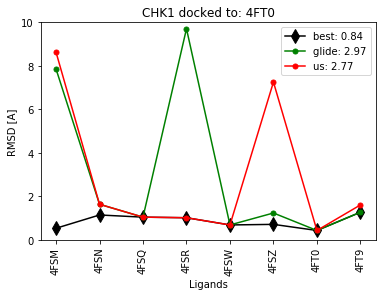

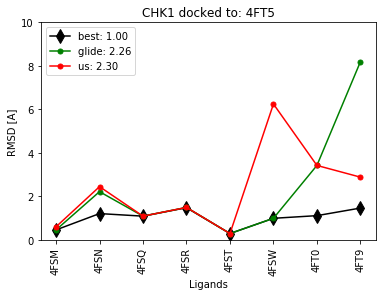

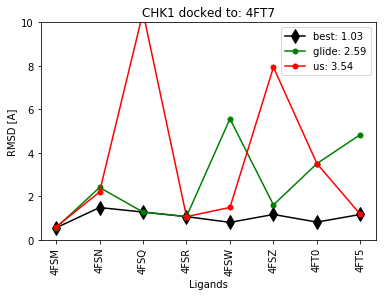

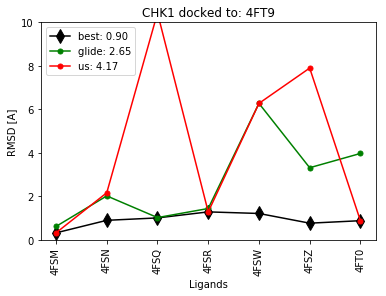

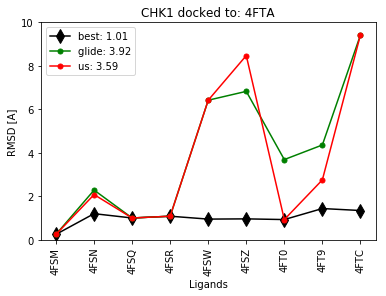

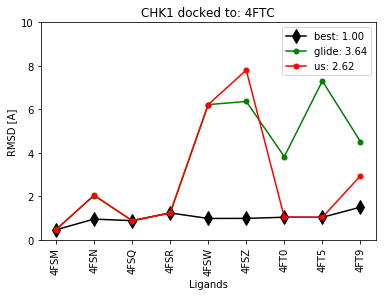

average rmsd across all structures: 3.03614 for us, 2.7674 for glide
MAP4K4
Loading crystal structures...
Loading glidescores...
0 of 180 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
average rmsd across all structures: nan for us, nan for glide
FXR
Loading crystal structures...
Loading glidescores...
20 of 180 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
average rmsd across all structures: nan for us, nan for glide
TRMD
Loading crystal structures...
Loading glidescores...
383 of 690 total pairs failed to dock.
Loading fingerprints...
Loading docking results...
3AXZ 4YPZ 3AXZ -1 0


AttributeError: 'NoneType' object has no attribute 'feats'

In [3]:
get_ipython().magic(u'matplotlib inline')
datasets = ['B2AR'] # ['HSP90', 'AR', 'B2AR', 'CDK2', 'CHK1', 'MAP4K4', 'FXR', 'TRMD']

compare_scores = False

all_us_final = []
all_glide_final = []

for receptor in datasets:
    print receptor
    data_set_dir = '/scratch/PI/rondror/docking_data/'+receptor+'/'
   
    xrmsd_file = 'xrmsd.csv'
    xglide_dir = data_set_dir + 'xglide/'
    crystal_fp_file = data_set_dir + '/ifp/crystal_ifp_2/ifp.fp'
    xdocking_fp_dir = data_set_dir + '/ifp/xglide_ifp_2/'
    
    w1 = [10,10,10,1,0]
    w2 = [10,10,10,0,0]
    
    (xcrystals, all_xglides) = load_data(
        data_set_dir, xrmsd_file, xglide_dir, crystal_fp_file, xdocking_fp_dir,w=w1)
    
    if compare_scores:
        (xcrystals2, all_xglides2) = load_data(
            data_set_dir, xrmsd_file, xglide_dir, crystal_fp_file, xdocking_fp_dir,w=w2)

    ligs = sorted(all_xglides.keys())
    if receptor == 'HSP90': ligs = hsp90_ligs(ligs)
    structs = []
    for l in ligs:
        structs.extend([i for i in all_xglides[l] if i not in structs])
    structs.sort()

    n = 25

    xglides = {l:{s:all_xglides[l][s] for s in all_xglides[l] if s in structs} for l in all_xglides if l in ligs}
    if compare_scores:
        xglides2 = {l:{s:all_xglides2[l][s] for s in all_xglides2[l] if s in structs} for l in all_xglides2 if l in ligs}

    if receptor == 'B2AR':
        b2ar_data(xcrystals, xglides)

    get_ipython().magic(u'matplotlib inline')

    best_rmsd_matrix = get_docking_stats(ligs, structs, xglides, n, lambda x: np.min(x) if x != [] else np.nan)
    
    us_final = []
    glide_final = []
    for struct in structs:
            
        filt_lig = [l for l in ligs if best_rmsd_matrix[structs.index(struct)][ligs.index(l)] < 1.5]
        
        if len(filt_lig) < 3: continue
        scores = Scores(xglides, xcrystals, filt_lig, struct, n)
        if compare_scores:
            scores2 = Scores(xglides2, xcrystals2, filt_lig, struct, n)
            final_rmsds = plot_final_rmsds(scores, receptor+' docked to: '+struct, scores2,'w2')
        else:
            final_rmsds = plot_final_rmsds(scores, receptor+' docked to: '+struct)
        #if struct == 'all': continue
        us_final.extend([i[1] for i in final_rmsds])
        glide_final.extend([i[3] for i in final_rmsds])
    
        all_us_final.extend([i[1] for i in final_rmsds])
        all_glide_final.extend([i[3] for i in final_rmsds])

    print 'average rmsd across all structures: {} for us, {} for glide'.format(np.mean(us_final), np.mean(glide_final))
    
print 'average rmsd across all receptors: {} for us, {} for glide'.format(np.mean(all_us_final), np.mean(all_glide_final))